In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
import kwant
print(kwant.version.version)
import kwantspectrum as ks

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import scipy as spi
import scipy.constants as const
import scipy.optimize as op
import scipy.misc as misc
import scipy.signal as signal
plt.rcParams.update({'font.size': 20})


#constants
hbar = const.hbar
m_e = const.m_e
eV = const.e
mu_B = const.physical_constants['Bohr magneton'][0]
B_c = np.sqrt(0.182**2.+0.887**2.)
B_T_c = B_c*const.e/1000.*2./14.7/mu_B
print(B_T_c)

1.4.2
2.1283060540757397


In [3]:
t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
print(1*(np.cos(0./2.)*t_x@s_y - np.sin(0./2.)*t_y@s_y))
print(1*spi.linalg.expm(1j*0*t_z/2.)@t_y@s_y)
print(0.182*2./1000.*eV/14.7/mu_B*2.)
print(np.sqrt(0.182**2.+(0.887-1.0141922225789335)**2.)/1000.*eV/14.7/mu_B*2.)
print(sigma_z)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j 

In [3]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A
#g = 14.7 #https://doi.org/10.1016/0375-9601(67)90541-5

def make_system_mixed(L_A=3700., W=1400., a=6.0583, m=0.023, alpha=350., mu=0., U_0=0., delta=0.182, B_Tesla=0.85, phi=0., g=14.7, salt='chizhang', eta=None):
    
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    L = int(np.round(L_A/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    E_plus = (6.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    E_minus = (-2.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    if eta is None:
        eta = np.sqrt(2)*alpha/W
    else:
        eta = eta
    nu = alpha/(2.*a)
    B = g*mu_B*B_Tesla/2./const.e*1000.
    print('Parameters: L, t, E_plus, E_minus, eta, nu, B')
    print([L, t, E_plus, E_minus, eta, nu, B])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
    t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
    t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
    sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
    sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
    sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
    s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
    s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
    s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
    
    #### Define onsite and hopping ####
    '''def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x'''
    
    #### Define the scattering region. ####
    ham = (2.*t+E_plus-mu)*t_z + E_minus*sigma_z@t_z + eta*s_x@sigma_y@t_z + B*s_x
    hop = -t*t_z + 1j*nu*s_y@t_z
    #ham_scl = delta*(np.cos(-phi/2.)*t_x@s_y@sigma_y - np.sin(-phi/2.)*t_y@s_y@sigma_y)
    #ham_scr = delta*(np.cos(phi/2.)*t_x@s_y@sigma_y - np.sin(phi/2.)*t_y@s_y@sigma_y)
    ham_scl = delta*(np.cos(-phi/2.)*t_x - np.sin(-phi/2.)*t_y)
    ham_scr = delta*(np.cos(phi/2.)*t_x - np.sin(phi/2.)*t_y)
    #ham_scl = delta*spi.linalg.expm(-1j*phi*t_z/2.)@t_y@s_y
    #ham_scr = delta*spi.linalg.expm(1j*phi*t_z/2.)@t_y@s_y
    
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(int(np.round(L/2.))))] = ham-U_0*t_z
    syst[((lat(x), lat(x+1)) for x in range(0, L-1))] = hop
    
    '''#### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')'''
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = ham+ham_scl
    lead0[lat.neighbors()] = hop
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  ham+ham_scr
    lead1[lat.neighbors()] = hop

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3, 28.885991119621014, 0.36333093758301105]


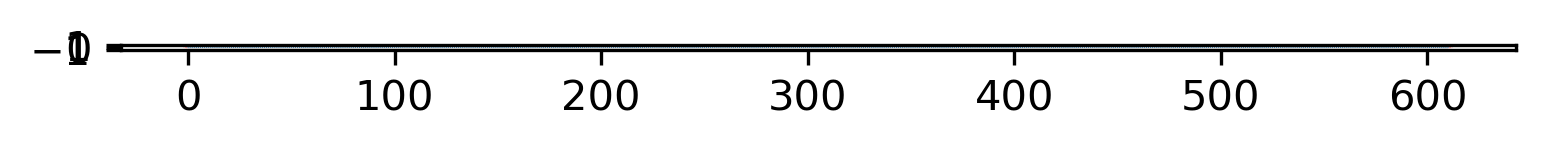

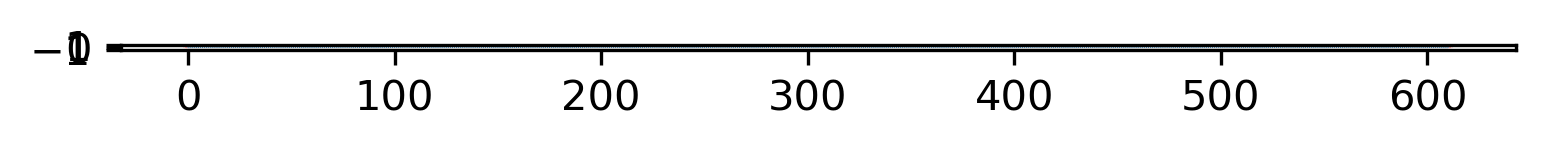

In [5]:
kwant.plot(make_system_mixed(B_Tesla=0.427*2., eta=0.3), dpi=300)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[6, 0.4513293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 0.28885991119621013, 0.36162915333203677]


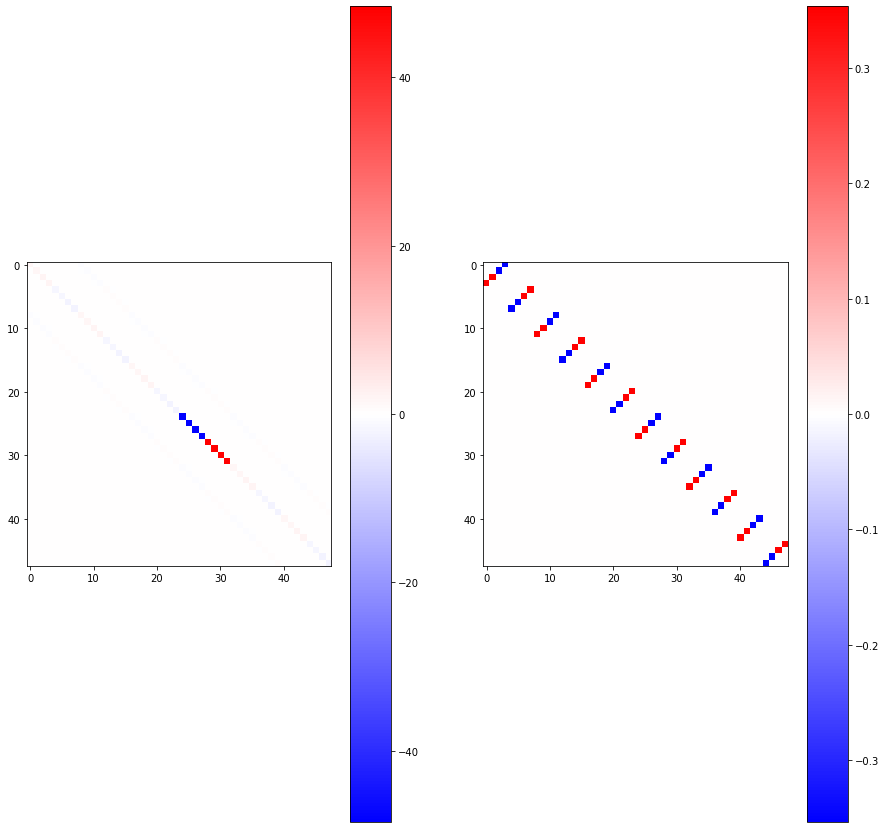

In [6]:
syst = make_system_mixed(phi=0., a=6.0583*100., U_0=50)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)

In [4]:
def dispersion(k_x_over_a, j, a=6.0583e-10, m_star=0.023, W_nm=140, alpha_meVnm=35):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    #print(alpha)
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    k_x = k_x_over_a/a
    #print(eta/eV*1000.)
    #print(E_2_perp/eV*1000)
    #print((E_2_perp - E_1_perp)/eV*1000.)
    #print((E_1_perp-E_2_perp)/(2.*(-1.)**j*alpha)*6.0583e-10)
    return ((hbar*k_x)**2./(2.*m_star*m_e) + (E_1_perp+E_2_perp)/2. - np.sqrt((((E_1_perp-E_2_perp)/2.)+(-1.)**j*alpha*k_x)**2.+eta**2.))/eV*1000.

In [8]:
print(dispersion(0.03, 1)-0.887)

2.08797385187536


Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
Spectral gap:
0.44465557296971286
Fermi momentum
4676374981.442444
Fermi wavelength:
1.343601685517853e-09
(array([4910, 5090]),)
[[0.44465557 0.44465557]]
[2.83308826 2.82177852]


'grad1 = v_F_given_mu()[0]*hbar*1000/eV/6.0583e-10\nprint(grad1)\ngrad2 = v_F_given_mu()[1]*hbar*1000/eV/6.0583e-10\ndef linear_func(k_x, k_0, E_0, grad):\n    return E_0+grad*(k_x-k_0)\nplt.plot(momenta, linear_func(momenta, k_F_given_mu(1)*6.0583e-10, dispersion(k_F_given_mu(1)*6.0583e-10, 1), grad1))\nplt.plot(momenta, linear_func(momenta, k_F_given_mu(2)*6.0583e-10, dispersion(k_F_given_mu(2)*6.0583e-10, 2), grad2))'

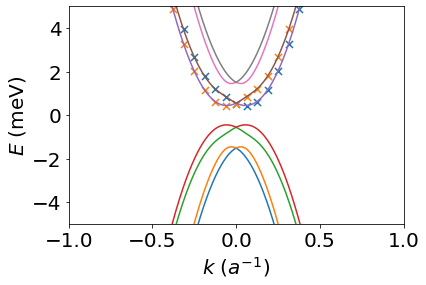

In [22]:
syst = make_system_mixed(B_Tesla=0., mu=0., eta=None, a=6.0583*10.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,10001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
plt.scatter(np.linspace(-np.pi,np.pi,101), dispersion(np.linspace(-np.pi,np.pi,101), 1, a=6.0583e-9), marker='x', s=50.)
plt.scatter(np.linspace(-np.pi,np.pi,101), dispersion(np.linspace(-np.pi,np.pi,101), 2, 6.0583e-9), marker='x', s=50.)
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 1), marker='x')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 2), marker='x')
plt.xlabel(r'$k$ ($a^{-1}$)')
plt.ylabel(r'$E$ (meV)')
plt.xlim(-1, 1)
plt.ylim(-5, 5)
plt.savefig('./BS validation thesis', dpi=300, bbox_inches='tight')
#plt.axhline(1.8)
#plt.axvline(0.016314840778883132)
#plt.axvline(0.0072165728173898625)
#plt.title(r'$B=1.35T, \mu=1.8meV$')
#plt.savefig('./Real params/dispersion a~60', dpi=300)

print('Spectral gap:')
print(np.min(en[:,4]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/6.0583e-10
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length

#try the scipy function
local_minima = signal.argrelextrema(en[:,4], np.less)
print(local_minima)
print(en[local_minima, 4])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))
#plt.savefig('./subband/effect of delta on band 4', dpi=300)

'''grad1 = v_F_given_mu()[0]*hbar*1000/eV/6.0583e-10
print(grad1)
grad2 = v_F_given_mu()[1]*hbar*1000/eV/6.0583e-10
def linear_func(k_x, k_0, E_0, grad):
    return E_0+grad*(k_x-k_0)
plt.plot(momenta, linear_func(momenta, k_F_given_mu(1)*6.0583e-10, dispersion(k_F_given_mu(1)*6.0583e-10, 1), grad1))
plt.plot(momenta, linear_func(momenta, k_F_given_mu(2)*6.0583e-10, dispersion(k_F_given_mu(2)*6.0583e-10, 2), grad2))'''

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.293, 28.885991119621014, 0.5743521847038231]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


0
0
0
0
2
[-0.01773774  0.01773774]
0
0
0


Text(0, 0.5, '$E_n(k)$')

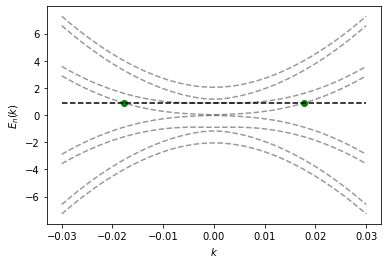

In [10]:
syst = make_system_mixed(B_Tesla=1.35, mu=0, eta=0.293)
spec = ks.spectrum(syst.leads[1])

kmin=-0.03
kmax=0.03
upper=0.887
momenta=np.linspace(-0.03, 0.03, 501)
plt.plot(momenta, spec(momenta), '--k', alpha=0.4)

for band in range(spec.nbands):
    cross = spec.intersect(upper, band, kmin=kmin, kmax=kmax)
    print(cross.size)
    if cross.size > 0:
        plt.plot(cross, spec(cross, band), 'go')
        print(cross)

    #velocity_zeros = spec.intersect(0, band, derivative_order=1, kmin=kmin, kmax=kmax)
    #plt.plot(velocity_zeros, spec(velocity_zeros, band), 'bo')

    #curvature_zeros = spec.intersect(0, band, derivative_order=2, kmin=kmin, kmax=kmax)
    #plt.plot(curvature_zeros, spec(curvature_zeros, band), 'ro')

    '''ie = spec.intervals(band, lower=lower, upper=upper, kmin=kmin, kmax=kmax)
    iv = spec.intervals(band, lower=0, derivative_order=1, kmin=kmin, kmax=kmax)
    intervals = ks.intersect_intervals(ie, iv)
    for interval in intervals:
        k = np.linspace(*interval)
        plt.plot(k, spec(k, band), 'k', linewidth=3.0)'''


plt.plot([kmin, kmax],[upper, upper], '--k')
plt.xlabel(r'$k$')
plt.ylabel(r'$E_n(k)$')
#plt.show()
#plt.savefig('subband/dispersion eta=0p35', dpi=300)

In [11]:
def lambda_F_given_B(B, mode=1):
    a = 6.0583e-10
    kmin=-0.03
    kmax=0.03
    upper=0.887
    syst = make_system_mixed(B_Tesla=B, mu=0.)
    spec = ks.spectrum(syst.leads[1])
    momenta=np.linspace(kmin, kmax, 501)
    
    k_F_array = []
    for band in range(spec.nbands):
        cross = spec.intersect(upper, band, kmin=kmin, kmax=kmax)
        if cross.size > 0:
            k_F_array.append(cross[-1])
    k_F_array = np.array(k_F_array)/a
    lambda_F_array = 2*np.pi/k_F_array
    print('len')
    print(len(lambda_F_array))
    if len(lambda_F_array) > 1:
        return lambda_F_array[mode]
    else:
        return lambda_F_array[0]
        


Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.0]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.042544606274357265]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.08508921254871453]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.12763381882307182]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.17017842509742906]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.2127230313717863]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.25526763764614363]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.2978122439205009]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.3403568501948581]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.3829014564692154]
len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.4254460627435726]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.46799066901792996]
len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5105352752922873]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5530798815666444]
len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5956244878410017]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.6381690941153589]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.6807137003897162]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.7232583066640735]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.7658029129384308]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.808347519212788]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.8508921254871452]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2


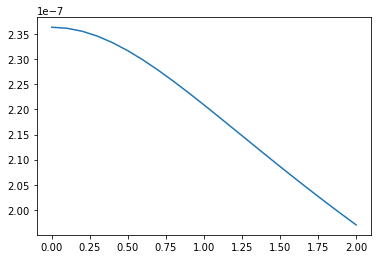

In [115]:
lambda_array = []
for B in np.linspace(0, 2, 21):
    lambda_array.append(lambda_F_given_B(B, mode=0))
plt.plot(np.linspace(0, 2, 21), lambda_array)

In [122]:
B_FP = op.brentq(lambda B: lambda_F_given_B(B, mode=0)-roots[3], 0, 2)
print(B_FP)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.0]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.8508921254871452]
len
2
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.47720523633933476]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5422117183293518]
len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5399714189558649]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5399730537379042]
len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5399730536441084]


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


len
1
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5399730536436829]
len
1
1.2691927389384825


/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/kwantspectrum/kwant_spectrum.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec = np.array([b * b / 3, 0, a * a])


In [121]:
'''def lambda_F_given_B(B):
    a = 6.0583e-10
    syst = make_system_mixed(B_Tesla=B, mu=0.887)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/a
    lambda_F = 2.*np.pi/k_F
    return lambda_F'''

roots = np.array([4.*3750e-10/(2.*i+1.) for i in range(0, 10)])
print(roots)


[1.50000000e-06 5.00000000e-07 3.00000000e-07 2.14285714e-07
 1.66666667e-07 1.36363636e-07 1.15384615e-07 1.00000000e-07
 8.82352941e-08 7.89473684e-08]


Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.5530798815666444]


Text(0.5, 1.0, '$B=0T, \\mu=0meV$')

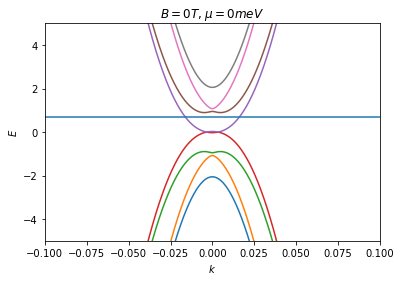

In [12]:
syst = make_system_mixed(B_Tesla=1.3, mu=0., delta=0.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
#plt.plot(momenta, dispersion(momenta, 1), ls=':')
#plt.plot(momenta, dispersion(momenta, 2), ls=':')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 1), marker='x')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 2), marker='x')
plt.axhline(0.7)
plt.xlabel(r'$k$')
plt.ylabel(r'$E$')
plt.xlim(-0.1, 0.1)
plt.ylim(-5, 5)
#plt.axhline(0.887)
#plt.axvline(0.016314840778883132)
#plt.axvline(0.0072165728173898625)
plt.title(r'$B=0T, \mu=0meV$')
#plt.savefig('./subband/effect of delta on band 2', dpi=300)


Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.3275934683125509]


Text(0.5, 1.0, '$B=0T, \\mu=1.5meV$')

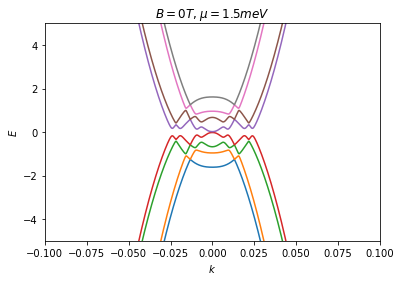

In [42]:
syst = make_system_mixed(B_Tesla=0.77, mu=1.8)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
#plt.plot(momenta, dispersion(momenta, 1), ls=':')
#plt.plot(momenta, dispersion(momenta, 2), ls=':')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 1), marker='x')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 2), marker='x')
plt.xlabel(r'$k$')
plt.ylabel(r'$E$')
plt.xlim(-0.1, 0.1)
plt.ylim(-5, 5)
#plt.axhline(0.887)
#plt.axvline(0.016314840778883132)
#plt.axvline(0.0072165728173898625)
plt.title(r'$B=0T, \mu=1.5meV$')

In [ ]:
gap_energies = []
for B in np.linspace(0, 2, 51):
    #fig=plt.figure()
    syst = make_system_mixed(B_Tesla=B, mu=1.8)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    gap_energies.append(np.min(en[:,4]))
    #plt.plot(momenta, en)
    #plt.xlabel(r'$k$')
    #plt.ylabel(r'$E$')
    #plt.xlim(-0.1, 0.1)
    #plt.ylim(-5, 5)
    #plt.title(r'$B=%.2fT, \mu=0.887$' % (B))
    #plt.savefig('./subband/gif 4/dispersion at B=%i over 1000 mu=0p6, ' % (int(B*1000)), dpi=300)

In [89]:
gap_energies_eta1 = []
gap_kF_eta1 = []
gap_energies_eta2 = []
gap_kF_eta2 = []
for eta in np.arange(0.21, 0.36, 0.01):
    syst = make_system_mixed(B_Tesla=1.35, mu=0.887, eta=eta)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    local_minima1 = signal.argrelextrema(en[:,4], np.less)
    local_gap1 = en[local_minima1, 4]
    local_minima2 = signal.argrelextrema(en[:,5], np.less)
    local_gap2 = en[local_minima2, 5]
    local_kF1 = np.linspace(-np.pi,np.pi,100001)[local_minima1]
    local_kF2 = np.linspace(-np.pi,np.pi,100001)[local_minima2]
    gap_energies_eta1.append(local_gap1)
    gap_kF_eta1.append(local_kF1)
    gap_energies_eta2.append(local_gap2)
    gap_kF_eta2.append(local_kF2)
print('done')

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.21, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.22, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.23, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.24000000000000002, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.25, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.26, 28.885991119621014, 0.5743521847038231]
Parameters: L, t, E_plus, E_minus, eta, nu,

In [13]:
gap_energies_B1 = []
gap_kF_B1 = []
gap_energies_B2 = []
gap_kF_B2 = []
for B in np.linspace(0, 2, 101):
    syst = make_system_mixed(B_Tesla=B, mu=0.887)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    local_minima1 = signal.argrelextrema(en[:,4], np.less)
    local_gap1 = en[local_minima1, 4]
    local_minima2 = signal.argrelextrema(en[:,5], np.less)
    local_gap2 = en[local_minima2, 5]
    local_kF1 = np.linspace(-np.pi,np.pi,100001)[local_minima1]
    local_kF2 = np.linspace(-np.pi,np.pi,100001)[local_minima2]
    gap_energies_B1.append(local_gap1)
    gap_kF_B1.append(local_kF1)
    gap_energies_B2.append(local_gap2)
    gap_kF_B2.append(local_kF2)
print('done')

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.0]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.008508921254871453]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.017017842509742906]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.02552676376461436]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.03403568501948581]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.885991119621014, 0.0

In [36]:
gap_energies_B1[0][0][int(np.floor(len(gap_energies_B1[0][0])/2))]

0.1820006266906846

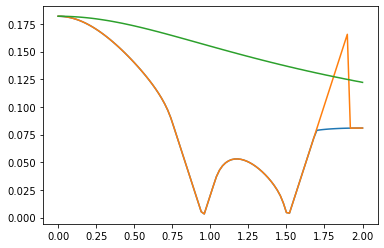

In [38]:
plt.plot(np.linspace(0, 2, 101), [np.min(gap_energies_B1[i]) for i in range(len(gap_energies_B1))])
plt.plot(np.linspace(0, 2, 101), [gap_energies_B1[i][0][int(np.floor(len(gap_energies_B1[i][0])/2))] for i in range(len(gap_energies_B1))])
plt.plot(np.linspace(0, 2, 101), [gap_energies_B1[i][0][-1] for i in range(len(gap_energies_B1))])
#plt.plot(np.linspace(0, 2, 101), [np.min(gap_energies_B2[i]) for i in range(len(gap_energies_B2))])
#plt.plot(np.linspace(0, 2, 101), [gap_energies_B2[i][0][-1] for i in range(len(gap_energies_B2))])
#gap_kF_B1
#gap_energies_B2

In [132]:
#print(gap_energies_B1)
print(gap_energies_B2)

[array([[0.3843748 , 0.33544679, 0.2785515 , 0.33544679, 0.3843748 ]]), array([[0.38431366, 0.33533963, 0.28706042, 0.33533963, 0.38431366]]), array([[0.38413027, 0.3350184 , 0.29556934, 0.3350184 , 0.38413027]]), array([[0.38382477, 0.33448381, 0.30407826, 0.33448381, 0.38382477]]), array([[0.38403153, 0.33373704, 0.31258718, 0.33373704, 0.38403153]]), array([[0.38432634, 0.33277975, 0.32109611, 0.33277975, 0.38432634]]), array([[0.38400215, 0.33161403, 0.32960503, 0.33161403, 0.38400215]]), array([[0.38331514, 0.33046172, 0.33811395, 0.33046172, 0.38331514]]), array([[0.38381238, 0.328869  , 0.34662287, 0.328869  , 0.38381238]]), array([[0.38316064, 0.32707446, 0.35513179, 0.32707446, 0.38316064]]), array([[0.3831869 , 0.32508188, 0.36364071, 0.32508188, 0.3831869 ]]), array([[0.38269507, 0.32289531, 0.37214963, 0.32289531, 0.38269507]]), array([[0.38281608, 0.32051914, 0.38065855, 0.32051914, 0.38281608]]), array([[0.38183356, 0.31806577, 0.31806577, 0.38183356]]), array([[0.3822694

In [100]:
print(gap_kF_eta1)
print(gap_energies_eta1)
print(gap_kF_eta2)
print(gap_energies_eta2)
print(gap_energies_eta1[0].flatten())

[array([-1.75929189e-02, -4.44089210e-16,  1.75929189e-02]), array([-1.75929189e-02, -4.44089210e-16,  1.75929189e-02]), array([-1.75929189e-02, -4.44089210e-16,  1.75929189e-02]), array([-1.76557507e-02, -4.44089210e-16,  1.76557507e-02]), array([-1.76557507e-02, -4.44089210e-16,  1.76557507e-02]), array([-1.76557507e-02, -4.44089210e-16,  1.76557507e-02]), array([-1.77185826e-02, -4.44089210e-16,  1.77185826e-02]), array([-1.77185826e-02, -4.44089210e-16,  1.77185826e-02]), array([-0.01771858, -0.00100531,  0.00100531,  0.01771858]), array([-0.01778141, -0.00144513,  0.00144513,  0.01778141]), array([-0.01778141, -0.00182212,  0.00182212,  0.01778141]), array([-0.01784425, -0.00207345,  0.00207345,  0.01784425]), array([-0.01784425, -0.00226195,  0.00226195,  0.01784425]), array([-0.01790708, -0.00245044,  0.00245044,  0.01790708]), array([-0.01790708, -0.00257611,  0.00257611,  0.01790708])]
[array([[0.15153202, 0.0185385 , 0.15153202]]), array([[0.15093253, 0.01346546, 0.15093253]]

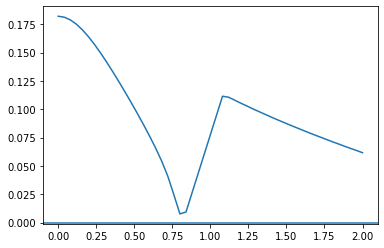

In [40]:
plt.plot(np.linspace(0, 2, 51), gap_energies)
#plt.ylim(0, 0)
plt.axhline(0)

In [76]:
np.linspace(0, 1, 2)*1000

array([   0., 1000.])

None


# Validation

## ABS spectra in Tosi

In [24]:
def phi_scan(phi_array=[0, 4.*np.pi], L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B_Tesla=0., g=14.7, salt='chizhang', eta=None):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(phi_array[0], phi_array[1], 41):
        print(i)
        syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, U_0=U_0, delta=delta, B_Tesla=B_Tesla, g=g, phi=i, salt='chizhang', eta=eta)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [123]:
def B_scan(phi=0, L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B_Tesla_array=[0., 2], g=14.7, salt='chizhang', eta=None):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(B_Tesla_array[0], B_Tesla_array[1]):
        print(i)
        syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, U_0=U_0, delta=delta, B_Tesla=i, g=g, phi=phi, salt='chizhang', eta=eta)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [ ]:
e_array1, psi_array1 = phi_scan()

In [ ]:
e_array1prime, psi_array1prime = phi_scan(B_Tesla=2.1283060540757397)

In [ ]:
e_array2, psi_array2 = phi_scan()

In [ ]:
e_array3, psi_array3 = phi_scan()

In [ ]:
e_array4, psi_array4 = phi_scan(W=1e9)

In [ ]:
e_array5, psi_array5 = phi_scan(B_Tesla=1.1)

In [ ]:
e_array6, psi_array6 = phi_scan(B_Tesla=1.35)

In [ ]:
e_array7, psi_array7 = phi_scan(B_Tesla=1.35, U_0=0.)

In [ ]:
e_array8, psi_array8 = phi_scan(B_Tesla=1.35, U_0=0., mu=1.8)

In [ ]:
e_array9, psi_array9 = phi_scan(B_Tesla=1.35, U_0=5., mu=1.8)

In [ ]:
e_array10, psi_array10 = B_scan()

In [ ]:
e_array11, psi_array11 = phi_scan(B_Tesla=1.35, U_0=0.)

In [ ]:
e_array12, psi_array12 = phi_scan(B_Tesla=1.35, U_0=5.)

In [ ]:
e_array13, psi_array13 = phi_scan(B_Tesla=1.35, U_0=0.)

In [ ]:
e_array14, psi_array14 = phi_scan(B_Tesla=1.35, U_0=5.)

In [ ]:
e_array15, psi_array15 = phi_scan(B_Tesla=1.35, U_0=0.)

In [ ]:
e_array16, psi_array16 = phi_scan(B_Tesla=1.35, U_0=5.)

In [ ]:
e_array17, psi_array17 = phi_scan(B_Tesla=1.35, U_0=0., eta=0.3)

In [ ]:
e_array18, psi_array18 = B_scan(eta=0.)

In [ ]:
e_phi_eta_array = []
for eta in np.linspace(0.31, 0.35, 5):
    print('eta:')
    print(eta)
    e_temp, _ = phi_scan(B_Tesla=1.35, U_0=0., eta=eta)
    e_phi_eta_array.append(e_temp)

In [ ]:
e_phi_eta_array2 = []
for eta in np.linspace(0.342, 0.348, 4):
    print('eta:')
    print(eta)
    e_temp, _ = phi_scan(B_Tesla=1.35, U_0=0., eta=eta)
    e_phi_eta_array2.append(e_temp)

In [ ]:
e_phi_eta_array3 = []
for eta in np.linspace(0.21, 0.29, 9):
    print('eta:')
    print(eta)
    e_temp, _ = phi_scan(B_Tesla=1.35, U_0=0., eta=eta)
    e_phi_eta_array3.append(e_temp)

In [ ]:
e_phi_U_0_array = []
for U_0 in np.linspace(0.1, 1, 10):
    print('U_0:')
    print(U_0)
    e_temp, _ = phi_scan(B_Tesla=1.35, U_0=U_0)
    e_phi_U_0_array.append(e_temp)

In [229]:
def k_F_given_mu(j, m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.887):
    def func(k_x):
        #print(k_x)
        #print(dispersion(k_x, j, a=a, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm)-mu_meV)
        return dispersion(k_x, j, a=a, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm)-mu_meV
    k_F = op.brentq(func, 0, 0.03)
    return k_F/a

def v_F_given_mu(m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.887):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    
    k_F1 = k_F_given_mu(1, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm, a=a, mu_meV=mu_meV)
    k_F2 = k_F_given_mu(2, m_star, W_nm, alpha_meVnm, a, mu_meV)
    
    #print(k_F1-k_F2-2.*m_star*m_e*alpha/hbar**2.)
    
    v_1 = hbar*k_F1/(m_star*m_e) + (-1)**1*(alpha*((E_1_perp/2.)-(-1)**1*alpha*k_F1))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**1*alpha*k_F1)**2. + eta**2.))
    v_2 = hbar*k_F2/(m_star*m_e) + (-1)**2*(alpha*((E_1_perp/2.)-(-1)**2*alpha*k_F2))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**2*alpha*k_F2)**2. + eta**2.))
    
    #print(v_1-v_2)
    return np.array([v_1, v_2])


26929734.0489628
11911877.618126972
[84290.6779541  48382.05919565]


In [343]:
print(61*6.0583*10)

3695.563


In [ ]:
def lambda_i(j, delta=0.182, L=3700):
    delta_0 = delta/1000*eV
    L_0 = L*1e-10
    v_j = v_F_given_mu()[j-1]
    return delta_0*L_0/(hbar*v_j)

def transcendental_eq(e, phi, s):
    return np.sin(e*lambda_i(1, L=3695.563)-s*phi/2.-np.arccos(e))*np.sin(e*lambda_i(2, L=3695.563)+s*phi/2.-np.arccos(e))

def e_given_phi_s(phi, s):
    energies = np.linspace(0, 1, 101)
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(transcendental_eq(a, phi, s)) != np.sign(transcendental_eq(b, phi, s)):
                candidate = scipy.optimize.brentq(lambda e: transcendental_eq(e, phi, s), a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    return candidates

e_1 = []
e_2 = []
for phi in np.linspace(0, 4*np.pi, 101):
    e_1.append(e_given_phi_s(phi, -1))
    e_2.append(e_given_phi_s(phi, 1))
    
print(e_1)
print(e_2)
#print(op.brentq(lambda e: transcendental_eq(e, 4*np.pi*0.04, -1.), 0, 0.55))
#print(op.brentq(lambda e: transcendental_eq(e, 4*np.pi*0.04, -1.), 0.55, 1.))
plt.plot(np.linspace(0, 1, 101), transcendental_eq(np.linspace(0, 1, 101), 4*np.pi*0.05, -1))
plt.axhline(0, color='k', ls=':')

In [110]:
def phi_plot(energy_array, gap_energies1, gap_energies2, figure_title, delta=0.182, title=r'$L=3700, W=1400, mu=0.887, delta=0.182, B=0T$'):
    ex=[]
    ey=[]
    
    ex1=[]
    ey1=[]
    ex2=[]
    ey2=[]
    
    phi = np.linspace(0, 4.*np.pi, 41)
    phi1 = np.linspace(0, 4.*np.pi, 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
    '''for i in range(len(analytic_array[0])):
        for j in range(len(analytic_array[0][i])):
            ex1.append(phi1[i])
            ey1.append(analytic_array[0][i][j])
    for i in range(len(analytic_array[1])):
        for j in range(len(analytic_array[1][i])):
            ex2.append(phi1[i])
            ey2.append(analytic_array[1][i][j])'''
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.scatter(ex1, ey1, s=5, c='orange', marker='_')
    #plt.scatter(ex2, ey2, s=5, c='green', marker='_')
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
    #plt.ylim(-0.25, 0.25)
    '''for gap_energy1 in gap_energies1:
        plt.axhline(gap_energy1, color='k', ls='--')
    for gap_energy2 in gap_energies2:
        plt.axhline(gap_energy2, color='g', ls='--')'''
    plt.title(title)
    #plt.savefig('./subband/'+figure_title, dpi=300)

In [56]:
def B_plot(energy_array, figure_title, delta=0.182, title=r'$L=3700, W=1400, mu=0.887, delta=0.182, \phi=0$'):
    ex=[]
    ey=[]
    
    ex1=[]
    ey1=[]
    ex2=[]
    ey2=[]
    
    B = np.linspace(0, 2)
    B1 = np.linspace(0, 2)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(B[i])
            ey.append(energy_array[i][j])
    '''for i in range(len(analytic_array[0])):
        for j in range(len(analytic_array[0][i])):
            ex1.append(phi1[i])
            ey1.append(analytic_array[0][i][j])
    for i in range(len(analytic_array[1])):
        for j in range(len(analytic_array[1][i])):
            ex2.append(phi1[i])
            ey2.append(analytic_array[1][i][j])'''
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.scatter(ex1, ey1, s=5, c='orange', marker='_')
    #plt.scatter(ex2, ey2, s=5, c='green', marker='_')
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$B (T)$')
    #plt.ylabel(r'$E/\Delta$')
    #plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
    #plt.ylim(-1.1, 1.1)
    plt.title(title)
    #plt.savefig('./subband/'+figure_title, dpi=300)

In [ ]:
import pickle
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
e_B_replot = pickle.load(open('./subband/Data/B scan', 'rb'))
e_B_replot

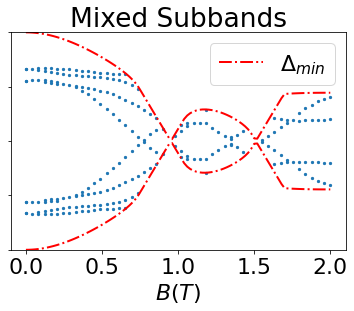

In [60]:
B_plot(e_B_replot, 'B scan (mu=0p887, eta=0)', title='Mixed Subbands')
plt.plot(np.linspace(0, 2, 101), np.array([np.min(gap_energies_B1[i]) for i in range(len(gap_energies_B1))])/0.182, c='red', label=r'$\Delta_{min}$', linestyle='-.', lw=2)
plt.plot(np.linspace(0, 2, 101), -np.array([np.min(gap_energies_B1[i]) for i in range(len(gap_energies_B1))])/0.182, c='red', linestyle='-.', lw=2)
plt.legend()
plt.yticks(ticks=[-1, -0.5, 0, 0.5, 1], labels=[])
plt.ylim(-1, 1)
plt.savefig('./poster_replots/fig2', dpi=300, bbox_inches='tight')
#plt.axvline(B_FP, ls='--', c='g')
#plt.axvline(B_FP2, ls='--', c='g')
#plt.savefig('./subband/B_scan with FP pts', dpi=300)

In [ ]:
e_phi_trivial_replot = pickle.load(open('./subband/Data/e_array1-really-really-correct', 'rb'))
e_phi_trivial_replot

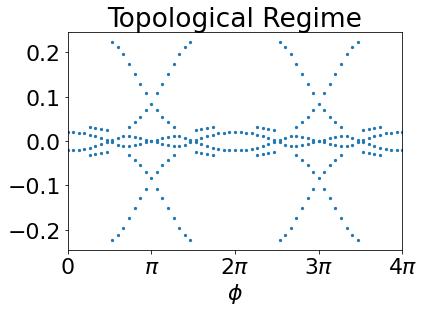

In [109]:
arr,waves,etas=pickle.load(open('./poster_scripts/Flat_band_highres','rb'))

phi_arr=np.linspace(0,2*np.pi,31)
new_data,new_phi=process_data(arr,phi_arr)


x,y=arrange_E(new_data[12],new_phi)

plt.locator_params(axis='y', nbins=5)
plt.scatter(x,np.array(y)/0.182, 5)
plt.xlabel(r'$\phi$')
#plt.ylabel(r'$E/\Delta$')
plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
plt.title('Topological Regime')
plt.xlim(0, 4*np.pi)
plt.savefig('./poster_replots/fig4', dpi=300, bbox_inches='tight')

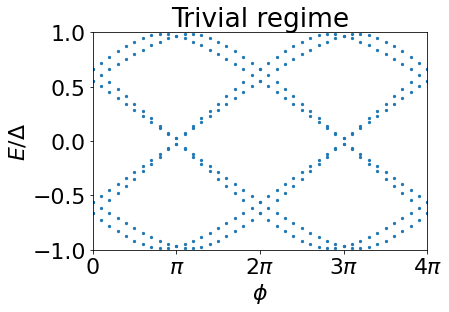

In [66]:
phi_plot(e_phi_trivial_replot, 0, 0, 'sth', title='Trivial regime')
plt.xlim(0, 4*np.pi)
plt.ylim(-1, 1)
plt.savefig('./poster_replots/fig3', dpi=300, bbox_inches='tight')

In [67]:
e_phi_replot_try = pickle.load(open('./poster_scripts/Flat_band_highres', 'rb'))

In [93]:
def process_data(arr,phi_arr,fill=True,extend=True,single=False):
    '''
    Takes the data, fills missing points, extend to 4pi
    Interpolation is not included since that one requires the tracking of
    specific branch solutions.
    If single, we are analysing only one solution/phi.
    '''
    if single:
        data=arr.copy()
        phic=np.array(phi_arr.copy())
        if fill:
            for j in range(len(data)):
                testdataj=[round(k,5) for k in data[j]]
                data[j]=np.append(data[j],[-k for k in data[j] if round(-k,5) not in testdataj])
                
        if extend: #extends the solution from 2pi to 4pi
            list1=list(reversed(data))
            data=data+list1[1:]
            list2=4*np.pi-np.array(list(reversed(phic))[1:])
            phic=np.append(phic,list2)
    
        return data,phic         
        
    l=len(arr)
    arrc=arr.copy() #making changes to new array rather than touching old one.
    phic=np.array(phi_arr.copy())
    for i in range(l):
        data=arrc[i]
        if fill: #fills all missing solutions. assuming they were lost due to rtol
            for j in range(len(data)):
                testdataj=[round(k,5) for k in data[j]]
                data[j]=np.append(data[j],[-k for k in data[j] if round(-k,5) not in testdataj])
                
        if extend: #extends the solution from 2pi to 4pi
            list1=list(reversed(data))
            arrc[i]=data+list1[1:]

    if extend: #extends the phi array as a final step
        list2=4*np.pi-np.array(list(reversed(phic))[1:])
        phic=np.append(phic,list2)
    
    return arrc,phic

In [96]:
def arrange_E(E_arr,phi_arr):
    '''
    Takes the output from boundstate algorithm and the scanned phases
    and arranges them into a single list for plotting.
    '''
    new_y=[]
    new_x=[]
    for i in range(len(phi_arr)):
        for j in range(len(E_arr[i])):
            new_x.append(phi_arr[i])
            new_y.append(E_arr[i][j])
    
    return new_x,new_y

In [91]:
e_phi_replot_try[2][12]

0.36

In [95]:
e_phi_replot_recons = process_data(e_phi_replot_try[0][12], np.linspace(0, 4*np.pi))
e_phi_replot_recons

TypeError: 'numpy.float64' object is not iterable

(0.0, 12.566370614359172)

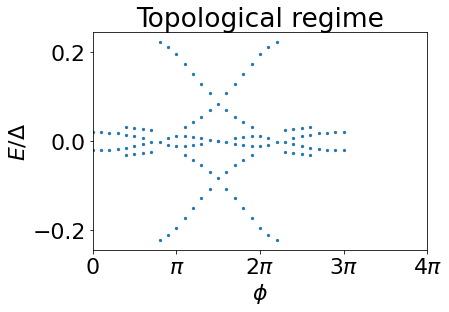

In [116]:
phi_plot(e_phi_replot_try[0][12], 0, 0, 'sth', title='Topological regime')
plt.xlim(0, 4*np.pi)
#plt.ylim(-1, 1)
#plt.savefig('./poster_replots/fig4', dpi=300, bbox_inches='tight')
#

In [112]:
e_eta0 = pickle.load(open('./subband/Data/eta=0 no barrier', 'rb'))
e_eta0

[array([-0.12183009, -0.08985041, -0.06043882, -0.03337631,  0.03337631,
         0.06043882,  0.08985041,  0.12183009]),
 array([-0.06091187, -0.0327201 ,  0.0327201 ,  0.06091187]),
 array([-0.1296629 , -0.08041611, -0.06218778, -0.03088864,  0.03088864,
         0.06218778,  0.08041611,  0.1296629 ]),
 array([-0.13611142, -0.07188372, -0.06395346, -0.02817716,  0.02817716,
         0.06395346,  0.07188372,  0.13611142]),
 array([-0.1424664 , -0.06590137, -0.06245303, -0.02486499,  0.02486499,
         0.06245303,  0.06590137,  0.1424664 ]),
 array([-0.14815851, -0.06779606, -0.0525256 , -0.02115268,  0.02115268,
         0.0525256 ,  0.06779606,  0.14815851]),
 array([-0.1527761 , -0.06947115, -0.04229343, -0.01717263,  0.01717263,
         0.04229343,  0.06947115,  0.1527761 ]),
 array([-0.15596979, -0.07081759, -0.03186407, -0.0130128 ,  0.0130128 ,
         0.03186407,  0.07081759,  0.15596979]),
 array([-0.15752784, -0.07177889, -0.02130673, -0.00873467,  0.00873467,
         0.

In [ ]:
for i in range(0, 9):
    plt.figure()
    phi_plot(e_phi_eta_array3[i], gap_energies_eta1[i].flatten()/0.182, gap_energies_eta2[i].flatten()/0.182, 'eta=0p2%s no barrier ylim' % (i+1), title=r'$L=3700, W=1400, \mu=1.8, \Delta=0.182, B=1.35T, U_0=0, \eta=0.2%i$' % (i+1))
#phi_plot(e_phi_eta_array3[0], gap_energies_eta1[0].flatten(), gap_energies_eta2[0].flatten(), 'eta=0p21 no barrier ylim', title=r'$L=3700, W=1400, \mu=1.8, \Delta=0.182, B=1.35T, U_0=0, \eta=0.21$')
#plt.plot(np.linspace(0, 4*np.pi), 0.08*np.cos(np.linspace(0, 4*np.pi)/2), c='r')
#plt.savefig('./subband/eta=0p3 no barrier cos', dpi=300)

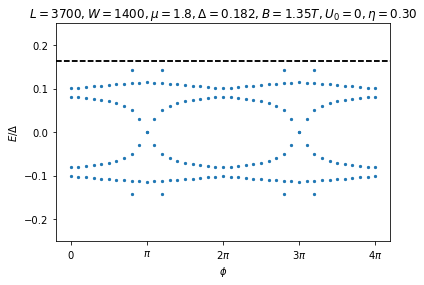

In [111]:
phi_plot(e_array17, gap_energies_eta1[9].flatten()/0.182, gap_energies_eta2[9].flatten()/0.182, 'eta=0p30 no barrier ylim', title=r'$L=3700, W=1400, \mu=1.8, \Delta=0.182, B=1.35T, U_0=0, \eta=0.30$')

In [133]:
import pickle
pickle.dump(e_array18, open('./subband/data/e_array18', 'wb'))

In [421]:
print('hello!')

hello!


In [100]:
e_array2, psi_array2 = phi_scan()

0.0
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.12140932 -0.12140932 -0.1011652  -0.1011652   0.1011652   0.1011652
  0.12140932  0.12140932]
0.3141592653589793
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.13179426 -0.11213561 -0.09171015  0.09171015  0.11213561  0.13179426]
0.6283185307179586
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.14165815 -0.11983259 -0.09892418 -0.08204064  0.08204064  0.09892418
  0.11983259  0.14165815]
0.9424777960769379
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.15084173 -0.12857358 -0.08736931 -0.0722